# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

# magic word for producing visualizations in notebook
%matplotlib inline

pd.options.display.max_rows = None
pd.options.display.max_columns = None

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
# Read with low_memory=True (default) to avoid loading entire file into memory for dtype inference
print("Loading data (this may take a moment)...")

try:
    # Read with low_memory=True - processes file in chunks internally
    azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';', low_memory=True)
    
    # Convert numeric columns to float32 to save memory (half the size)
    print("Optimizing data types to save memory...")
    numeric_cols = azdias.select_dtypes(include=['int64', 'float64']).columns
    for col in numeric_cols:
        azdias[col] = azdias[col].astype('float32')
    
    print(f"Data loaded successfully! Shape: {azdias.shape}")
    print(f"Memory usage: {azdias.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
except MemoryError as e:
    print(f"Memory error: {e}")
    print("Trying to free memory and read in smaller chunks...")
    import gc
    gc.collect()
    
    # Last resort: read in very small chunks
    chunks = []
    chunk_size = 10000  # Very small chunks
    
    for i, chunk in enumerate(pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';', 
                                          chunksize=chunk_size, low_memory=True)):
        # Convert numeric columns immediately
        for col in chunk.select_dtypes(include=['int64', 'float64']).columns:
            chunk[col] = chunk[col].astype('float32')
        chunks.append(chunk)
        if (i + 1) % 20 == 0:
            print(f"  Loaded {(i + 1) * chunk_size:,} rows...")
            gc.collect()  # Force garbage collection
    
    azdias = pd.concat(chunks, ignore_index=True)
    del chunks
    gc.collect()
    print(f"Data loaded! Shape: {azdias.shape}")

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')


Loading data (this may take a moment)...
Optimizing data types to save memory...
Data loaded successfully! Shape: (891221, 85)
Memory usage: 440.18 MB


In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print(f"General demographics data shape: {azdias.shape}")
print(f"\nFeature summary shape: {feat_info.shape}")
print(f"\nFirst few rows of demographics data:")
azdias.head()
print(f"\nFeature summary:")
feat_info.head()


General demographics data shape: (891221, 85)

Feature summary shape: (85, 4)

First few rows of demographics data:

Feature summary:


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [4]:
# Identify missing or unknown data values and convert them to NaNs.
def parse_missing_codes(missing_str):
    """Parse the missing value codes from string format to list."""
    if pd.isna(missing_str) or missing_str == '' or missing_str == '[]':
        return []
    # Remove brackets and split by comma
    missing_str = missing_str.strip('[]')
    if missing_str == '':
        return []
    # Try to convert each element
    codes = []
    for code in missing_str.split(','):
        code = code.strip()
        try:
            # Try integer first
            codes.append(int(code))
        except ValueError:
            # If not integer, keep as string
            codes.append(code)
    return codes

# Create a copy to work with
azdias_clean = azdias.copy()

# Convert missing value codes to NaNs
for idx, row in feat_info.iterrows():
    col_name = row['attribute']
    if col_name in azdias_clean.columns:
        missing_codes = parse_missing_codes(row['missing_or_unknown'])
        if missing_codes:
            azdias_clean[col_name] = azdias_clean[col_name].replace(missing_codes, np.nan)

print("Missing value codes converted to NaNs.")
print(f"Total missing values: {azdias_clean.isnull().sum().sum()}")


Missing value codes converted to NaNs.
Total missing values: 8373929


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [5]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
missing_per_col = azdias_clean.isnull().sum()
missing_percent = (missing_per_col / len(azdias_clean)) * 100

# Create a dataframe for easier analysis
missing_df = pd.DataFrame({
    'column': missing_per_col.index,
    'missing_count': missing_per_col.values,
    'missing_percent': missing_percent.values
}).sort_values('missing_percent', ascending=False)

print("Missing data per column:")
print(missing_df.head(20))


Missing data per column:
            column  missing_count  missing_percent
40        TITEL_KZ         889061        99.757636
0         AGER_TYP         685843        76.955435
47    KK_KUNDENTYP         584612        65.596749
64    KBA05_BAUMAX         476524        53.468668
11     GEBURTSJAHR         392318        44.020282
43        ALTER_HH         310267        34.813699
70             KKK         158064        17.735668
73        REGIOTYP         158064        17.735668
48  W_KEIT_KIND_HH         147988        16.605084
60     KBA05_ANTG1         133324        14.959701
65       KBA05_GBZ         133324        14.959701
61     KBA05_ANTG2         133324        14.959701
62     KBA05_ANTG3         133324        14.959701
63     KBA05_ANTG4         133324        14.959701
71      MOBI_REGIO         133324        14.959701
76      PLZ8_ANTG2         116515        13.073637
77      PLZ8_ANTG3         116515        13.073637
79     PLZ8_BAUMAX         116515        13.073637
78    

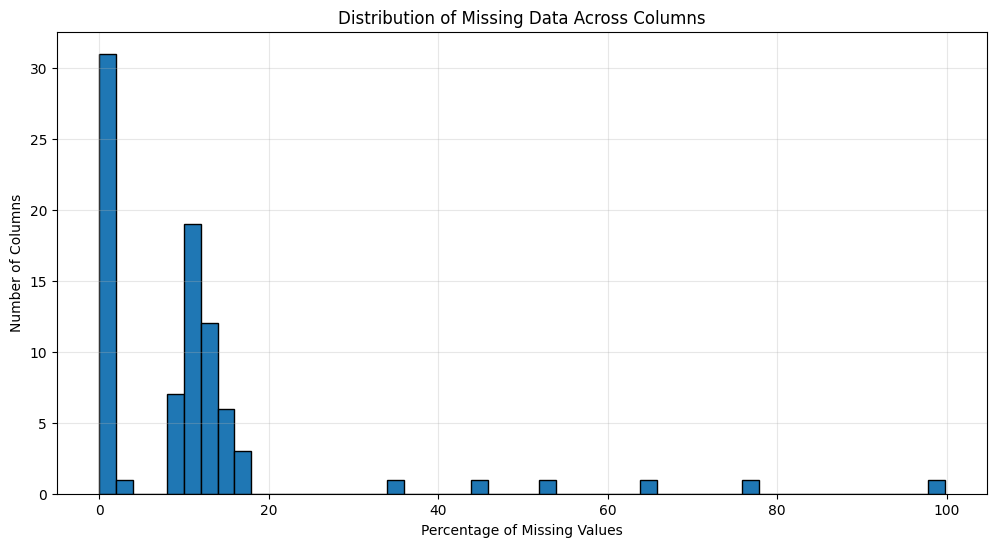


Outlier columns (>20% missing): ['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH']
Number of outlier columns: 6


In [6]:
# Investigate patterns in the amount of missing data in each column.
plt.figure(figsize=(12, 6))
plt.hist(missing_percent, bins=50, edgecolor='black')
plt.xlabel('Percentage of Missing Values')
plt.ylabel('Number of Columns')
plt.title('Distribution of Missing Data Across Columns')
plt.grid(True, alpha=0.3)
plt.show()

# Identify outlier columns (those with >20% missing data)
outlier_cols = missing_df[missing_df['missing_percent'] > 20]['column'].tolist()
print(f"\nOutlier columns (>20% missing): {outlier_cols}")
print(f"Number of outlier columns: {len(outlier_cols)}")


In [7]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
azdias_clean = azdias_clean.drop(columns=outlier_cols)
print(f"Removed {len(outlier_cols)} outlier columns.")
print(f"New shape: {azdias_clean.shape}")


Removed 6 outlier columns.
New shape: (891221, 79)


#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

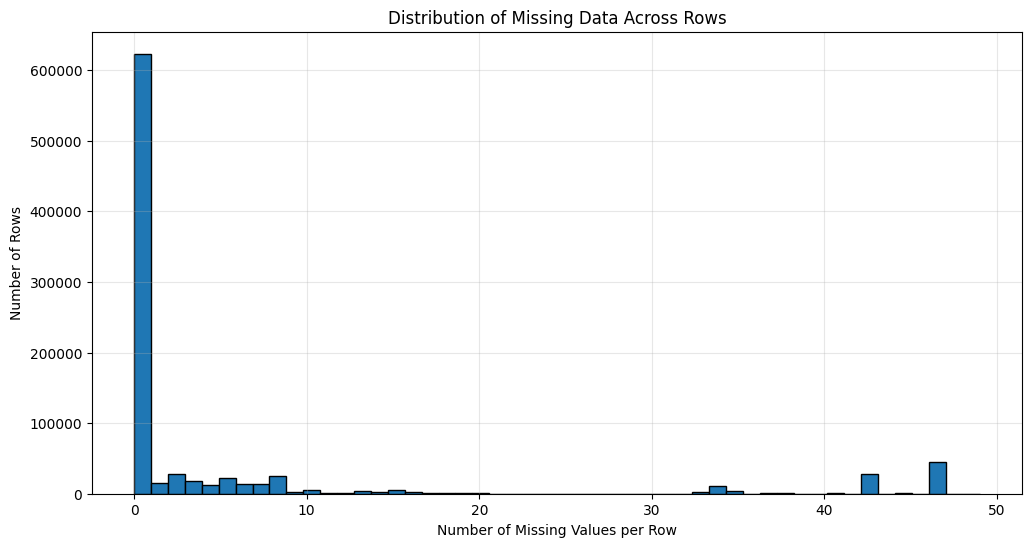

Statistics on missing values per row:
count    891221.000000
mean          5.649894
std          13.234687
min           0.000000
25%           0.000000
50%           0.000000
75%           3.000000
max          49.000000
dtype: float64


In [8]:
# How much data is missing in each row of the dataset?
missing_per_row = azdias_clean.isnull().sum(axis=1)

plt.figure(figsize=(12, 6))
plt.hist(missing_per_row, bins=50, edgecolor='black')
plt.xlabel('Number of Missing Values per Row')
plt.ylabel('Number of Rows')
plt.title('Distribution of Missing Data Across Rows')
plt.grid(True, alpha=0.3)
plt.show()

print(f"Statistics on missing values per row:")
print(missing_per_row.describe())


In [9]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
# Use threshold of 20 missing values per row
threshold = 20
azdias_low_missing = azdias_clean[missing_per_row < threshold].copy()
azdias_high_missing = azdias_clean[missing_per_row >= threshold].copy()

print(f"Rows with < {threshold} missing values: {len(azdias_low_missing)} ({len(azdias_low_missing)/len(azdias_clean)*100:.2f}%)")
print(f"Rows with >= {threshold} missing values: {len(azdias_high_missing)} ({len(azdias_high_missing)/len(azdias_clean)*100:.2f}%)")


Rows with < 20 missing values: 797077 (89.44%)
Rows with >= 20 missing values: 94144 (10.56%)


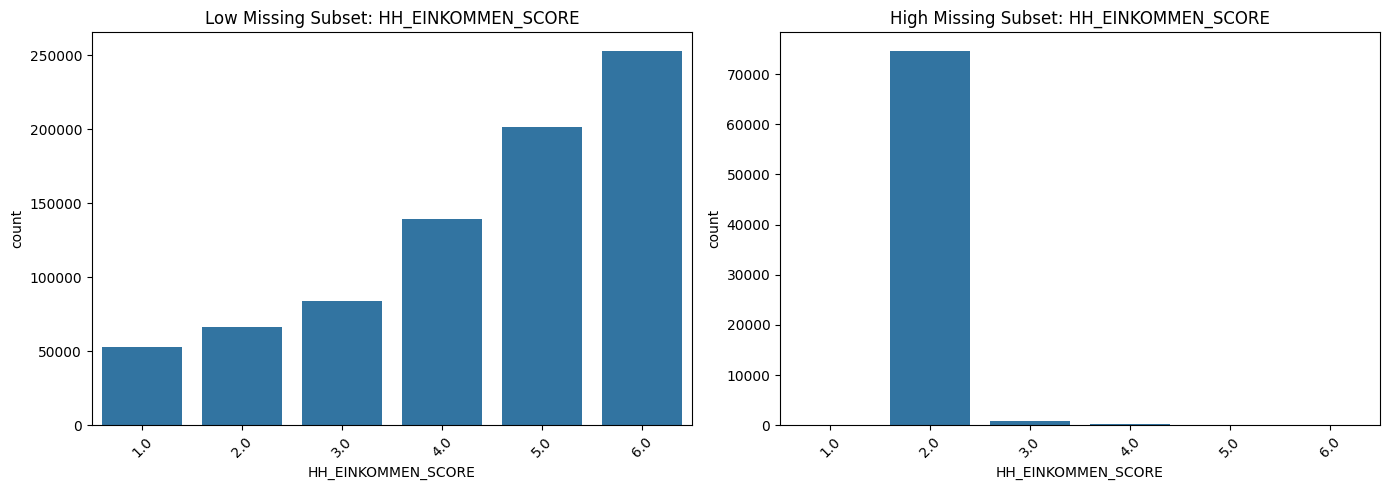

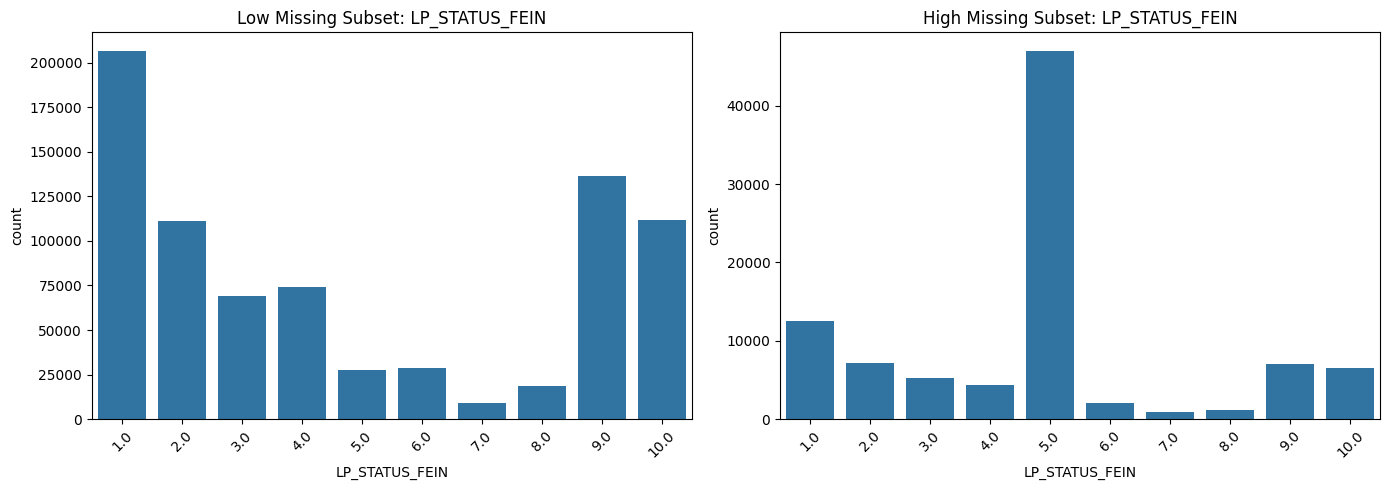

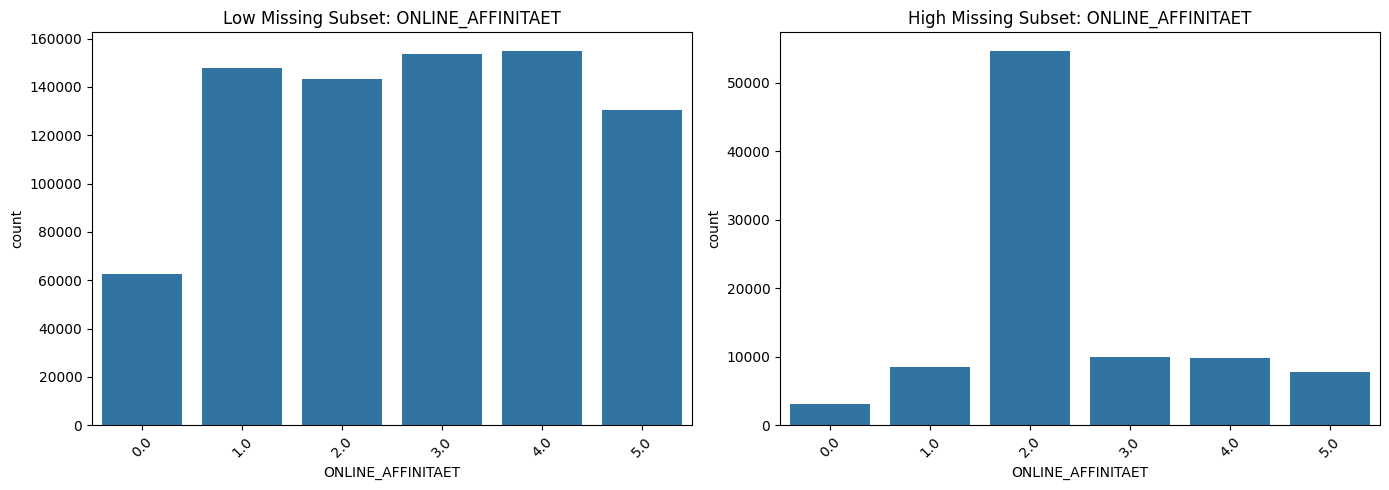

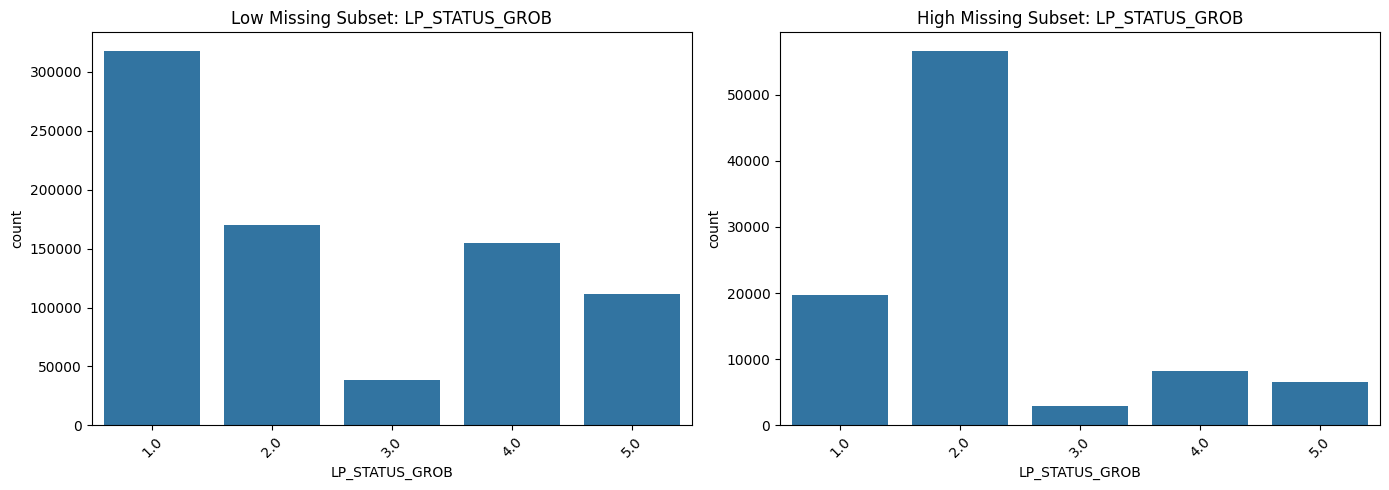

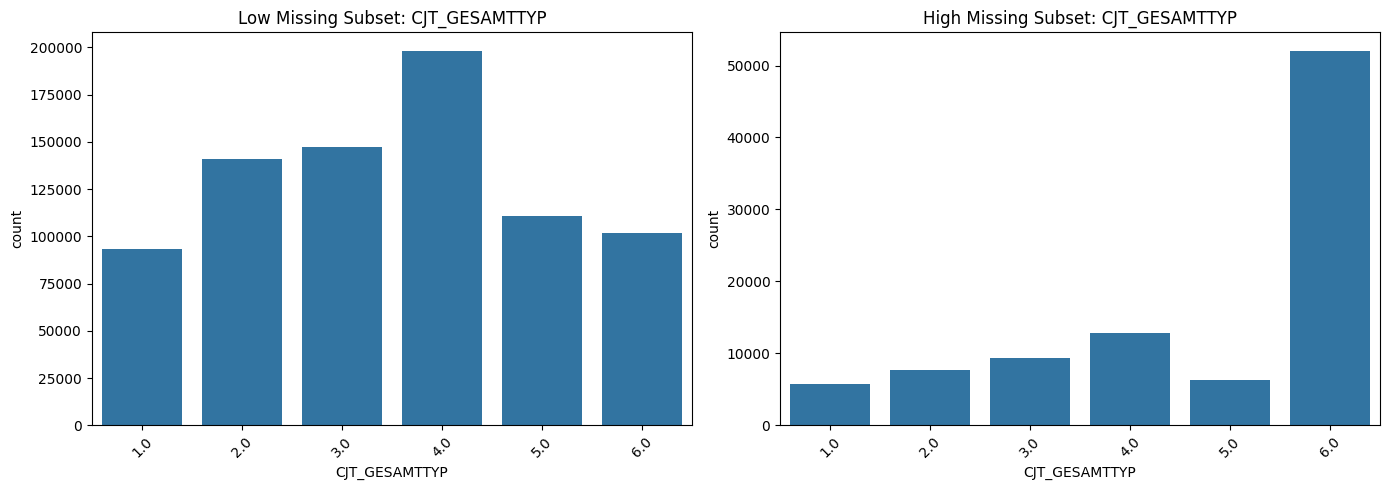

In [10]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
def compare_distributions(col_name):
    """Compare distribution of a column between low and high missing subsets."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Low missing subset
    sns.countplot(data=azdias_low_missing, x=col_name, ax=axes[0])
    axes[0].set_title(f'Low Missing Subset: {col_name}')
    axes[0].tick_params(axis='x', rotation=45)
    
    # High missing subset
    sns.countplot(data=azdias_high_missing, x=col_name, ax=axes[1])
    axes[1].set_title(f'High Missing Subset: {col_name}')
    axes[1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

# Find columns with few missing values
low_missing_cols = missing_df[missing_df['missing_percent'] < 5]['column'].tolist()
# Filter to columns that exist in our cleaned dataset
low_missing_cols = [col for col in low_missing_cols if col in azdias_clean.columns]

# Compare distributions for 5 columns
for col in low_missing_cols[:5]:
    if col in azdias_low_missing.columns and col in azdias_high_missing.columns:
        compare_distributions(col)


#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [11]:
# How many features are there of each data type?
# Filter feat_info to only include columns that still exist
feat_info_clean = feat_info[feat_info['attribute'].isin(azdias_low_missing.columns)]
data_type_counts = feat_info_clean['type'].value_counts()
print("Features by data type:")
print(data_type_counts)


Features by data type:
type
ordinal        49
categorical    18
mixed           6
numeric         6
Name: count, dtype: int64


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [12]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
categorical_features = feat_info_clean[feat_info_clean['type'] == 'categorical']['attribute'].tolist()
categorical_features = [col for col in categorical_features if col in azdias_low_missing.columns]

binary_categorical = []
multi_level_categorical = []

for col in categorical_features:
    unique_vals = azdias_low_missing[col].dropna().unique()
    if len(unique_vals) == 2:
        binary_categorical.append(col)
        # Check if values are numeric
        if azdias_low_missing[col].dtype == 'object':
            print(f"Binary categorical with non-numeric values: {col}, values: {unique_vals}")
    elif len(unique_vals) > 2:
        multi_level_categorical.append(col)

print(f"\nBinary categorical features ({len(binary_categorical)}): {binary_categorical}")
print(f"\nMulti-level categorical features ({len(multi_level_categorical)}): {multi_level_categorical}")


Binary categorical with non-numeric values: OST_WEST_KZ, values: ['W' 'O']

Binary categorical features (5): ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']

Multi-level categorical features (13): ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [13]:
# Re-encode categorical variable(s) to be kept in the analysis.
# Re-encode binary categorical with non-numeric values (OST_WEST_KZ)
if 'OST_WEST_KZ' in azdias_low_missing.columns:
    azdias_low_missing['OST_WEST_KZ'] = azdias_low_missing['OST_WEST_KZ'].map({'W': 0, 'O': 1})

# For multi-level categoricals, we'll use one-hot encoding
# But first, let's check how many levels each has
for col in multi_level_categorical:
    unique_count = azdias_low_missing[col].nunique()
    print(f"{col}: {unique_count} unique values")

# One-hot encode multi-level categoricals (dropping original columns)
azdias_encoded = pd.get_dummies(azdias_low_missing, columns=multi_level_categorical, prefix=multi_level_categorical)

print(f"\nShape after encoding: {azdias_encoded.shape}")


CJT_GESAMTTYP: 6 unique values
FINANZTYP: 6 unique values
GFK_URLAUBERTYP: 12 unique values
LP_FAMILIE_FEIN: 11 unique values
LP_FAMILIE_GROB: 5 unique values
LP_STATUS_FEIN: 10 unique values
LP_STATUS_GROB: 5 unique values
NATIONALITAET_KZ: 3 unique values
SHOPPER_TYP: 4 unique values
ZABEOTYP: 6 unique values
GEBAEUDETYP: 7 unique values
CAMEO_DEUG_2015: 9 unique values
CAMEO_DEU_2015: 44 unique values

Shape after encoding: (797077, 194)


#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [14]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
# Mapping based on Data_Dictionary.md
# Decade: 1=40s, 2=40s, 3=50s, 4=50s, 5=60s, 6=60s, 7=60s, 8=70s, 9=70s, 10=80s, 11=80s, 12=80s, 13=80s, 14=90s, 15=90s
# Movement: 1=Mainstream, 2=Avantgarde (alternating pattern)

def map_decade(x):
    if pd.isna(x):
        return np.nan
    decade_map = {1: 1, 2: 1, 3: 2, 4: 2, 5: 3, 6: 3, 7: 3, 8: 4, 9: 4, 
                  10: 5, 11: 5, 12: 5, 13: 5, 14: 6, 15: 6}
    return decade_map.get(x, np.nan)

def map_movement(x):
    if pd.isna(x):
        return np.nan
    # Mainstream: 1,3,5,8,10,12,14
    # Avantgarde: 2,4,6,7,9,11,13,15
    mainstream = [1, 3, 5, 8, 10, 12, 14]
    return 0 if x in mainstream else 1

if 'PRAEGENDE_JUGENDJAHRE' in azdias_encoded.columns:
    azdias_encoded['PRAEGENDE_JUGENDJAHRE_DECADE'] = azdias_encoded['PRAEGENDE_JUGENDJAHRE'].apply(map_decade)
    azdias_encoded['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = azdias_encoded['PRAEGENDE_JUGENDJAHRE'].apply(map_movement)
    print("Created PRAEGENDE_JUGENDJAHRE_DECADE and PRAEGENDE_JUGENDJAHRE_MOVEMENT")


Created PRAEGENDE_JUGENDJAHRE_DECADE and PRAEGENDE_JUGENDJAHRE_MOVEMENT


In [15]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
# Split two-digit code: tens place = wealth, ones place = life stage
def map_wealth(x):
    if pd.isna(x) or x == 'XX' or x == 'nan':
        return np.nan
    try:
        x_str = str(x)
        if len(x_str) >= 2:
            return int(x_str[0])  # Tens place
        return np.nan
    except:
        return np.nan

def map_life_stage(x):
    if pd.isna(x) or x == 'XX' or x == 'nan':
        return np.nan
    try:
        x_str = str(x)
        if len(x_str) >= 2:
            return int(x_str[1])  # Ones place
        return np.nan
    except:
        return np.nan

if 'CAMEO_INTL_2015' in azdias_encoded.columns:
    azdias_encoded['CAMEO_INTL_2015_WEALTH'] = azdias_encoded['CAMEO_INTL_2015'].apply(map_wealth)
    azdias_encoded['CAMEO_INTL_2015_LIFE_STAGE'] = azdias_encoded['CAMEO_INTL_2015'].apply(map_life_stage)
    print("Created CAMEO_INTL_2015_WEALTH and CAMEO_INTL_2015_LIFE_STAGE")


Created CAMEO_INTL_2015_WEALTH and CAMEO_INTL_2015_LIFE_STAGE


#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [16]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)



In [17]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
# Remove original mixed-type columns that we've engineered
mixed_features = feat_info_clean[feat_info_clean['type'] == 'mixed']['attribute'].tolist()
mixed_features = [col for col in mixed_features if col in azdias_encoded.columns]

# Remove the original mixed columns we've engineered
columns_to_remove = ['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015']
columns_to_remove = [col for col in columns_to_remove if col in azdias_encoded.columns]

azdias_final = azdias_encoded.drop(columns=columns_to_remove)

print(f"Final shape: {azdias_final.shape}")
print(f"Removed columns: {columns_to_remove}")


Final shape: (797077, 196)
Removed columns: ['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015']


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [18]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    df_clean = df.copy()
    
    # Load feat_info (use global if available, otherwise load from file)
    try:
        feat_info = globals()['feat_info']
    except KeyError:
        feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')
    
    def parse_missing_codes(missing_str):
        if pd.isna(missing_str) or missing_str == '' or missing_str == '[]':
            return []
        missing_str = missing_str.strip('[]')
        if missing_str == '':
            return []
        codes = []
        for code in missing_str.split(','):
            code = code.strip()
            try:
                codes.append(int(code))
            except ValueError:
                codes.append(code)
        return codes
    
    for idx, row in feat_info.iterrows():
        col_name = row['attribute']
        if col_name in df_clean.columns:
            missing_codes = parse_missing_codes(row['missing_or_unknown'])
            if missing_codes:
                df_clean[col_name] = df_clean[col_name].replace(missing_codes, np.nan)
    
    # remove selected columns and rows, ...
    # Remove outlier columns (>20% missing)
    missing_per_col = df_clean.isnull().sum()
    missing_percent = (missing_per_col / len(df_clean)) * 100
    outlier_cols = missing_percent[missing_percent > 20].index.tolist()
    df_clean = df_clean.drop(columns=outlier_cols)
    
    # Remove rows with >= 20 missing values
    missing_per_row = df_clean.isnull().sum(axis=1)
    df_clean = df_clean[missing_per_row < 20].copy()
    
    # select, re-encode, and engineer column values.
    # Re-encode OST_WEST_KZ
    if 'OST_WEST_KZ' in df_clean.columns:
        df_clean['OST_WEST_KZ'] = df_clean['OST_WEST_KZ'].map({'W': 0, 'O': 1})
    
    # Get categorical features
    feat_info_clean = feat_info[feat_info['attribute'].isin(df_clean.columns)]
    categorical_features = feat_info_clean[feat_info_clean['type'] == 'categorical']['attribute'].tolist()
    categorical_features = [col for col in categorical_features if col in df_clean.columns]
    
    multi_level = []
    for col in categorical_features:
        if df_clean[col].nunique() > 2:
            multi_level.append(col)
    
    # One-hot encode multi-level categoricals
    if multi_level:
        df_clean = pd.get_dummies(df_clean, columns=multi_level, prefix=multi_level)
    
    # Engineer PRAEGENDE_JUGENDJAHRE
    if 'PRAEGENDE_JUGENDJAHRE' in df_clean.columns:
        decade_map = {1: 1, 2: 1, 3: 2, 4: 2, 5: 3, 6: 3, 7: 3, 8: 4, 9: 4, 
                      10: 5, 11: 5, 12: 5, 13: 5, 14: 6, 15: 6}
        df_clean['PRAEGENDE_JUGENDJAHRE_DECADE'] = df_clean['PRAEGENDE_JUGENDJAHRE'].map(decade_map)
        mainstream = [1, 3, 5, 8, 10, 12, 14]
        df_clean['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = df_clean['PRAEGENDE_JUGENDJAHRE'].apply(
            lambda x: 0 if x in mainstream else 1 if pd.notna(x) else np.nan
        )
        df_clean = df_clean.drop(columns=['PRAEGENDE_JUGENDJAHRE'])
    
    # Engineer CAMEO_INTL_2015
    if 'CAMEO_INTL_2015' in df_clean.columns:
        df_clean['CAMEO_INTL_2015_WEALTH'] = df_clean['CAMEO_INTL_2015'].apply(
            lambda x: int(str(x)[0]) if pd.notna(x) and str(x) != 'XX' and str(x) != 'nan' and len(str(x)) >= 2 else np.nan
        )
        df_clean['CAMEO_INTL_2015_LIFE_STAGE'] = df_clean['CAMEO_INTL_2015'].apply(
            lambda x: int(str(x)[1]) if pd.notna(x) and str(x) != 'XX' and str(x) != 'nan' and len(str(x)) >= 2 else np.nan
        )
        df_clean = df_clean.drop(columns=['CAMEO_INTL_2015'])
    
    # Return the cleaned dataframe.
    return df_clean
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [19]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
print(f"Missing values before imputation: {azdias_final.isnull().sum().sum()}")

# Use SimpleImputer to fill missing values with median (for numeric) or most_frequent
from sklearn.preprocessing import StandardScaler

# Separate numeric and non-numeric columns
numeric_cols = azdias_final.select_dtypes(include=[np.number]).columns.tolist()
non_numeric_cols = azdias_final.select_dtypes(exclude=[np.number]).columns.tolist()

# Separate boolean columns from other non-numeric columns (SimpleImputer doesn't support bool)
bool_cols = azdias_final.select_dtypes(include=['bool']).columns.tolist()
non_numeric_non_bool_cols = [col for col in non_numeric_cols if col not in bool_cols]

# Convert boolean columns to int before imputation (if any exist)
if bool_cols:
    azdias_final[bool_cols] = azdias_final[bool_cols].astype(int)
    # Add boolean columns to numeric_cols for imputation
    numeric_cols.extend(bool_cols)

# Convert numeric columns to float32 to save memory (half the size of float64/int64)
for col in numeric_cols:
    if azdias_final[col].dtype in ['int64', 'int32', 'float64']:
        azdias_final[col] = azdias_final[col].astype('float32')

# Impute numeric columns with median using pandas (more memory efficient than sklearn for large datasets)
# Compute medians first (pandas is efficient for this)
median_values = {}
for col in numeric_cols:
    median_val = azdias_final[col].median()
    median_values[col] = 0.0 if pd.isna(median_val) else median_val
    azdias_final[col] = azdias_final[col].fillna(median_values[col])

# Create and fit imputer for later use on customer data
# Manually set statistics to avoid memory issues during fit
imputer = SimpleImputer(strategy='median')
# Create a small dummy array to fit (sklearn requires this)
dummy_data = np.array([[median_values.get(col, 0.0) for col in numeric_cols]])
imputer.fit(dummy_data)
# Manually set the statistics to our computed medians
imputer.statistics_ = np.array([median_values.get(col, 0.0) for col in numeric_cols])

# For any remaining non-numeric, non-boolean columns, use most_frequent
# Use pandas mode() which is more memory efficient
if non_numeric_non_bool_cols:
    most_frequent_values = {}
    for col in non_numeric_non_bool_cols:
        mode_val = azdias_final[col].mode()
        most_frequent_values[col] = mode_val[0] if len(mode_val) > 0 else ''
        azdias_final[col] = azdias_final[col].fillna(most_frequent_values[col])
    
    # Create and fit imputer for later use on customer data
    imputer_freq = SimpleImputer(strategy='most_frequent')
    # Create a small dummy array to fit
    dummy_data = np.array([[most_frequent_values.get(col, '') for col in non_numeric_non_bool_cols]], dtype=object)
    imputer_freq.fit(dummy_data)
    # Manually set the statistics
    imputer_freq.statistics_ = np.array([most_frequent_values.get(col, '') for col in non_numeric_non_bool_cols], dtype=object)

print(f"Missing values after imputation: {azdias_final.isnull().sum().sum()}")


Missing values before imputation: 864544
Missing values after imputation: 0


In [20]:
# Apply feature scaling to the general population demographics data.
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
azdias_scaled = scaler.fit_transform(azdias_final)
azdias_scaled = pd.DataFrame(azdias_scaled, columns=azdias_final.columns)

print(f"Scaled data shape: {azdias_scaled.shape}")
print(f"Scaled data statistics:")
print(azdias_scaled.describe())


Scaled data shape: (797077, 196)
Scaled data statistics:
       ALTERSKATEGORIE_GROB     ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
count          7.970770e+05  7.970770e+05       7.970770e+05   7.970770e+05   
mean           8.698775e-08  9.005070e-08       3.062949e-08   4.326415e-08   
std            1.000001e+00  1.000001e+00       1.000001e+00   1.000001e+00   
min           -1.766173e+00 -1.043709e+00      -1.494463e+00  -1.155407e+00   
25%           -7.827196e-01 -1.043709e+00      -7.685471e-01  -1.155407e+00   
50%            2.007335e-01  9.581212e-01      -4.263090e-02   1.913661e-01   
75%            1.184187e+00  9.581212e-01       6.832853e-01   8.647526e-01   
max            1.184187e+00  9.581212e-01       1.409202e+00   1.538139e+00   

       FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  \
count      7.970770e+05    7.970770e+05           7.970770e+05   
mean      -3.675539e-08   -4.288129e-09          -8.913182e-08   
std        1.000001e+00    1.0000

### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [21]:
# Apply PCA to the data.
from sklearn.decomposition import PCA

# Start with all components to see variance explained
pca = PCA()
azdias_pca = pca.fit_transform(azdias_scaled)

print(f"PCA applied. Number of components: {len(pca.components_)}")


PCA applied. Number of components: 196


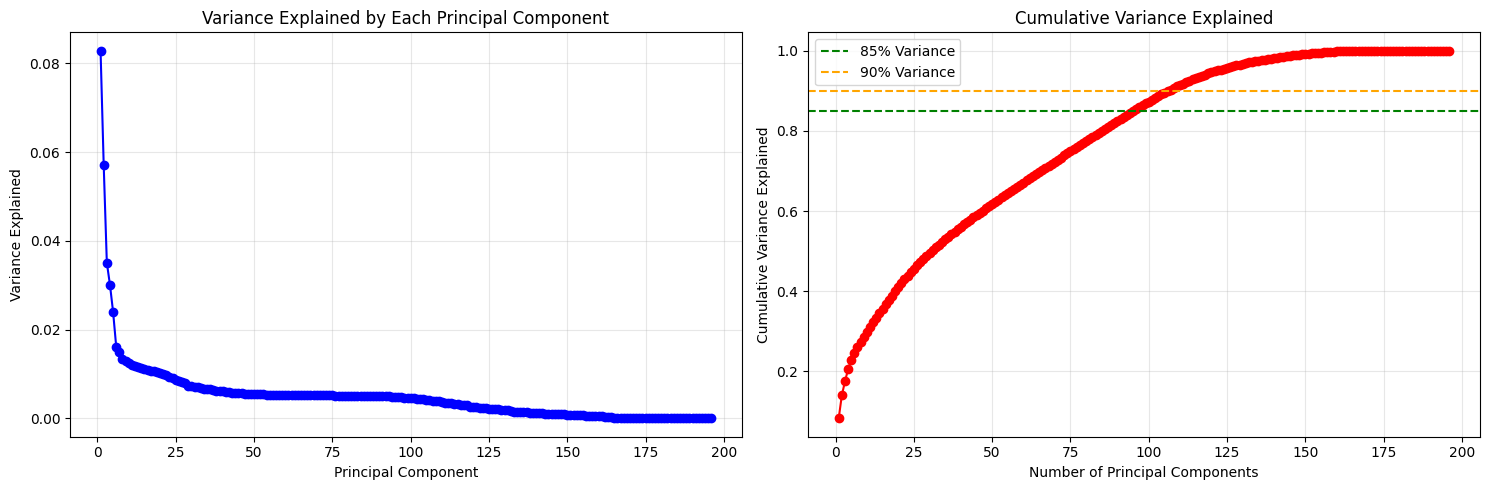

Number of components for 85% variance: 95
Number of components for 90% variance: 107
First 10 components variance: [0.08282246 0.05708388 0.03505971 0.03008294 0.02396297 0.01610574
 0.0149954  0.01337621 0.01297795 0.01252204]


In [22]:
# Investigate the variance accounted for by each principal component.
# Calculate variance explained
variance_explained = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(variance_explained)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Individual variance
axes[0].plot(range(1, len(variance_explained) + 1), variance_explained, 'bo-')
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Variance Explained')
axes[0].set_title('Variance Explained by Each Principal Component')
axes[0].grid(True, alpha=0.3)

# Cumulative variance
axes[1].plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'ro-')
axes[1].axhline(y=0.85, color='g', linestyle='--', label='85% Variance')
axes[1].axhline(y=0.90, color='orange', linestyle='--', label='90% Variance')
axes[1].set_xlabel('Number of Principal Components')
axes[1].set_ylabel('Cumulative Variance Explained')
axes[1].set_title('Cumulative Variance Explained')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Find number of components for 85% and 90% variance
n_components_85 = np.argmax(cumulative_variance >= 0.85) + 1
n_components_90 = np.argmax(cumulative_variance >= 0.90) + 1

print(f"Number of components for 85% variance: {n_components_85}")
print(f"Number of components for 90% variance: {n_components_90}")
print(f"First 10 components variance: {variance_explained[:10]}")


In [23]:
# Re-apply PCA to the data while selecting for number of components to retain.
# Choose number of components (using 85% variance as target)
n_components = n_components_85  # or choose another value based on analysis

pca_final = PCA(n_components=n_components)
azdias_pca_final = pca_final.fit_transform(azdias_scaled)

# Convert to float64 for KMeans (it expects double precision)
azdias_pca_final = azdias_pca_final.astype('float64')

print(f"Final PCA shape: {azdias_pca_final.shape}")
print(f"Variance explained by {n_components} components: {pca_final.explained_variance_ratio_.sum():.4f}")


Final PCA shape: (797077, 95)
Variance explained by 95 components: 0.8501


### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [24]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def pca_weights(pca, component_num, feature_names):
    """Get and sort weights for a principal component."""
    weights = pca.components_[component_num]
    weights_df = pd.DataFrame({
        'feature': feature_names,
        'weight': weights
    })
    weights_df = weights_df.sort_values('weight', key=abs, ascending=False)
    return weights_df

# First component
weights_pc1 = pca_weights(pca_final, 0, azdias_scaled.columns)
print("Top 10 features for PC1 (by absolute weight):")
print(weights_pc1.head(10))
print("\nBottom 10 features for PC1 (by absolute weight):")
print(weights_pc1.tail(10))


Top 10 features for PC1 (by absolute weight):
                    feature    weight
50               MOBI_REGIO  0.199498
114      LP_STATUS_GROB_1.0 -0.188861
40              KBA05_ANTG1  0.183248
31       HH_EINKOMMEN_SCORE -0.180117
2         FINANZ_MINIMALIST  0.179550
194  CAMEO_INTL_2015_WEALTH -0.179425
54               PLZ8_ANTG1  0.179351
56               PLZ8_ANTG3 -0.178302
44                KBA05_GBZ  0.175937
57               PLZ8_ANTG4 -0.173110

Bottom 10 features for PC1 (by absolute weight):
                  feature    weight
85   GFK_URLAUBERTYP_10.0  0.002212
174     CAMEO_DEU_2015_6C -0.001827
166     CAMEO_DEU_2015_5A -0.001648
128          ZABEOTYP_3.0  0.001486
12         RETOURTYP_BK_S  0.001477
170     CAMEO_DEU_2015_5E  0.001399
101   LP_FAMILIE_GROB_3.0 -0.001388
175     CAMEO_DEU_2015_6D -0.000908
123       SHOPPER_TYP_1.0  0.000795
136       GEBAEUDETYP_5.0 -0.000356


In [25]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
weights_pc2 = pca_weights(pca_final, 1, azdias_scaled.columns)
print("Top 10 features for PC2 (by absolute weight):")
print(weights_pc2.head(10))
print("\nBottom 10 features for PC2 (by absolute weight):")
print(weights_pc2.tail(10))


Top 10 features for PC2 (by absolute weight):
                          feature    weight
192  PRAEGENDE_JUGENDJAHRE_DECADE  0.242013
0            ALTERSKATEGORIE_GROB -0.237563
3                   FINANZ_SPARER  0.233847
4                FINANZ_VORSORGER -0.223424
15                      SEMIO_REL  0.217551
6           FINANZ_UNAUFFAELLIGER  0.216812
26                    SEMIO_TRADV  0.210790
25                  SEMIO_PFLICHT  0.209710
5                  FINANZ_ANLEGER  0.207079
128                  ZABEOTYP_3.0 -0.199457

Bottom 10 features for PC2 (by absolute weight):
                            feature    weight
188               CAMEO_DEU_2015_9B  0.001545
164               CAMEO_DEU_2015_4D  0.001453
8                  GREEN_AVANTGARDE -0.001190
193  PRAEGENDE_JUGENDJAHRE_MOVEMENT -0.001190
116              LP_STATUS_GROB_3.0  0.000647
124                 SHOPPER_TYP_2.0 -0.000506
112              LP_STATUS_FEIN_9.0  0.000467
148               CAMEO_DEU_2015_1A  0.000322
149   

In [26]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
weights_pc3 = pca_weights(pca_final, 2, azdias_scaled.columns)
print("Top 10 features for PC3 (by absolute weight):")
print(weights_pc3.head(10))
print("\nBottom 10 features for PC3 (by absolute weight):")
print(weights_pc3.tail(10))


Top 10 features for PC3 (by absolute weight):
           feature    weight
1        ANREDE_KZ  0.338211
17      SEMIO_VERT -0.314133
24      SEMIO_KAEM  0.306469
23       SEMIO_DOM  0.273970
22      SEMIO_KRIT  0.264425
14       SEMIO_FAM -0.254975
13       SEMIO_SOZ -0.253778
20      SEMIO_KULT -0.246390
19       SEMIO_ERL  0.205160
5   FINANZ_ANLEGER  0.155448

Bottom 10 features for PC3 (by absolute weight):
               feature    weight
42         KBA05_ANTG3 -0.000622
186  CAMEO_DEU_2015_8D  0.000617
27             SOHO_KZ -0.000567
136    GEBAEUDETYP_5.0 -0.000566
155  CAMEO_DEU_2015_2C  0.000345
38         OST_WEST_KZ  0.000326
164  CAMEO_DEU_2015_4D  0.000187
177  CAMEO_DEU_2015_6F -0.000106
175  CAMEO_DEU_2015_6D -0.000072
153  CAMEO_DEU_2015_2A -0.000030


### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [27]:
# Over a number of different cluster counts...
from sklearn.cluster import KMeans

# Test different numbers of clusters
cluster_counts = range(2, 21, 2)  # Test 2, 4, 6, ..., 20 clusters
scores = []

print("Testing different numbers of clusters...")
for n_clusters in cluster_counts:
    # run k-means clustering on the data and...
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    kmeans.fit(azdias_pca_final)
    
    # compute the average within-cluster distances.
    # Note: score() returns negative inertia, so we take the absolute value
    score = abs(kmeans.score(azdias_pca_final))
    scores.append(score)
    print(f"Clusters: {n_clusters}, Score: {score:.2f}")

print("\nCompleted cluster testing.")
    
    
    # compute the average within-cluster distances.
    
    

Testing different numbers of clusters...
Clusters: 2, Score: 122899027.12
Clusters: 4, Score: 115478471.88
Clusters: 6, Score: 111569119.02
Clusters: 8, Score: 108744543.46
Clusters: 10, Score: 106863030.90
Clusters: 12, Score: 105704938.55
Clusters: 14, Score: 103840198.55
Clusters: 16, Score: 102083347.95
Clusters: 18, Score: 101388932.31
Clusters: 20, Score: 99696100.83

Completed cluster testing.


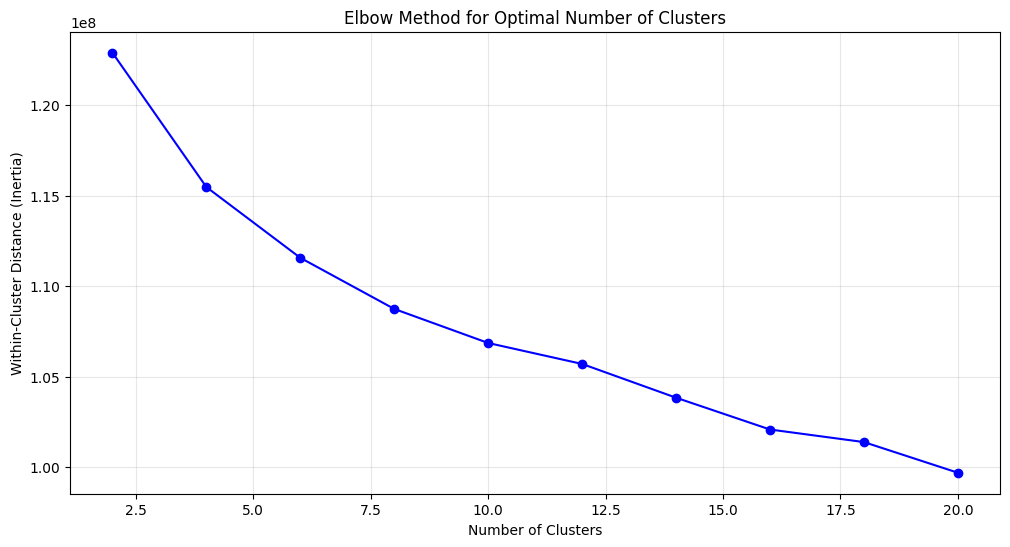

Rate of change in scores:
4 clusters: -7420555.24
6 clusters: -3909352.86
8 clusters: -2824575.56
10 clusters: -1881512.56
12 clusters: -1158092.35
14 clusters: -1864740.00
16 clusters: -1756850.60
18 clusters: -694415.64
20 clusters: -1692831.48


In [28]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.figure(figsize=(12, 6))
plt.plot(cluster_counts, scores, 'bo-')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Distance (Inertia)')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.grid(True, alpha=0.3)
plt.show()

# Calculate the rate of change (elbow point)
if len(scores) > 1:
    rate_of_change = np.diff(scores)
    print("Rate of change in scores:")
    for i, (n_clust, change) in enumerate(zip(cluster_counts[1:], rate_of_change)):
        print(f"{n_clust} clusters: {change:.2f}")


In [29]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
# Choose optimal number of clusters (e.g., based on elbow method, let's use 10)
optimal_clusters = 10  # Adjust based on your analysis

kmeans_final = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
azdias_clusters = kmeans_final.fit_predict(azdias_pca_final)

print(f"Fitted KMeans with {optimal_clusters} clusters")
print(f"Cluster assignments shape: {azdias_clusters.shape}")
print(f"Cluster distribution:")
unique, counts = np.unique(azdias_clusters, return_counts=True)
for cluster, count in zip(unique, counts):
    print(f"  Cluster {cluster}: {count} points ({count/len(azdias_clusters)*100:.2f}%)")


Fitted KMeans with 10 clusters
Cluster assignments shape: (797077,)
Cluster distribution:
  Cluster 0: 35218 points (4.42%)
  Cluster 1: 69881 points (8.77%)
  Cluster 2: 83586 points (10.49%)
  Cluster 3: 79467 points (9.97%)
  Cluster 4: 80588 points (10.11%)
  Cluster 5: 104335 points (13.09%)
  Cluster 6: 85919 points (10.78%)
  Cluster 7: 99881 points (12.53%)
  Cluster 8: 106200 points (13.32%)
  Cluster 9: 52002 points (6.52%)


### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [30]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')
print(f"Customer data shape: {customers.shape}")

Customer data shape: (191652, 85)


In [31]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

# Clean customer data
customers_clean = clean_data(customers)

# Align columns with general population (add missing columns, remove extra)
# Get columns that exist in both
common_cols = list(set(azdias_final.columns) & set(customers_clean.columns))
missing_cols = set(azdias_final.columns) - set(customers_clean.columns)

# Add missing columns with 0 values
for col in missing_cols:
    customers_clean[col] = 0

# Reorder columns to match azdias_final
customers_clean = customers_clean[azdias_final.columns]

# Convert boolean columns to int (same as in general population processing)
bool_cols = customers_clean.select_dtypes(include=['bool']).columns.tolist()
if bool_cols:
    customers_clean[bool_cols] = customers_clean[bool_cols].astype(int)

# Impute missing values using the same imputer
customers_clean[numeric_cols] = imputer.transform(customers_clean[numeric_cols])
if non_numeric_non_bool_cols:
    customers_clean[non_numeric_non_bool_cols] = imputer_freq.transform(customers_clean[non_numeric_non_bool_cols])

# Scale using the same scaler
customers_scaled = scaler.transform(customers_clean)
customers_scaled = pd.DataFrame(customers_scaled, columns=customers_clean.columns)

# Apply PCA transformation
customers_pca = pca_final.transform(customers_scaled)

# Convert to float64 for KMeans (it expects double precision)
customers_pca = customers_pca.astype('float64')

# Get cluster predictions
customers_clusters = kmeans_final.predict(customers_pca)

print(f"Customer data processed. Shape: {customers_pca.shape}")
print(f"Cluster assignments completed.")


C:\Users\sebas\AppData\Local\Temp\ipykernel_46308\3261941677.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  customers_clean[col] = 0
C:\Users\sebas\AppData\Local\Temp\ipykernel_46308\3261941677.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  customers_clean[col] = 0
C:\Users\sebas\AppData\Local\Temp\ipykernel_46308\3261941677.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once usin

Customer data processed. Shape: (191652, 95)
Cluster assignments completed.


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

Cluster Proportion Comparison:
   General Population  Customers  Difference
9            6.524087  74.802768   68.278680
7           12.530910  25.197232   12.666323
0            4.418394   0.000000   -4.418394
1            8.767158   0.000000   -8.767158
3            9.969802   0.000000   -9.969802
4           10.110441   0.000000  -10.110441
2           10.486565   0.000000  -10.486565
6           10.779260   0.000000  -10.779260
5           13.089701   0.000000  -13.089701
8           13.323681   0.000000  -13.323681


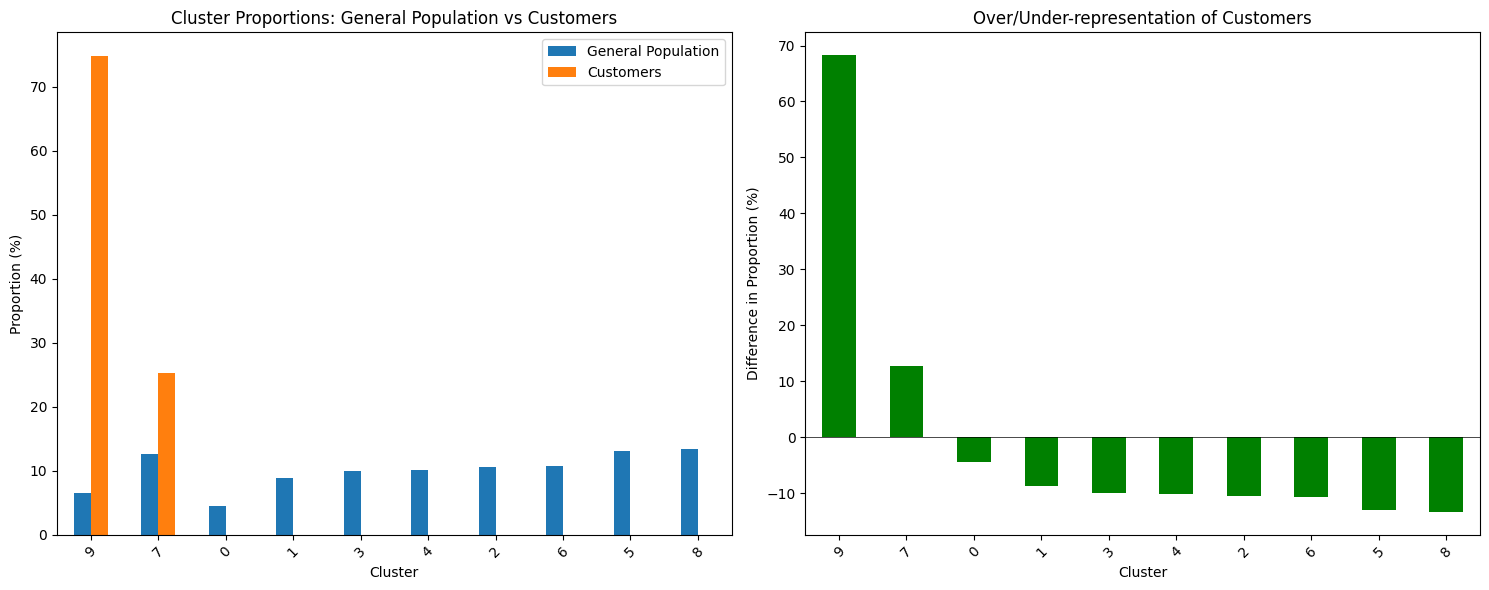


Overrepresented clusters (customers > general population):
   General Population  Customers  Difference
9            6.524087  74.802768   68.278680
7           12.530910  25.197232   12.666323

Underrepresented clusters (customers < general population):
   General Population  Customers  Difference
8           13.323681        0.0  -13.323681
5           13.089701        0.0  -13.089701
6           10.779260        0.0  -10.779260
2           10.486565        0.0  -10.486565
4           10.110441        0.0  -10.110441


In [32]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

# Calculate proportions
general_cluster_counts = pd.Series(azdias_clusters).value_counts().sort_index()
customer_cluster_counts = pd.Series(customers_clusters).value_counts().sort_index()

general_proportions = general_cluster_counts / len(azdias_clusters) * 100
customer_proportions = customer_cluster_counts / len(customers_clusters) * 100

# Create comparison dataframe
comparison_df = pd.DataFrame({
    'General Population': general_proportions,
    'Customers': customer_proportions
}).fillna(0)
comparison_df['Difference'] = comparison_df['Customers'] - comparison_df['General Population']
comparison_df = comparison_df.sort_values('Difference', ascending=False)

print("Cluster Proportion Comparison:")
print(comparison_df)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Bar plot comparison
comparison_df[['General Population', 'Customers']].plot(kind='bar', ax=axes[0])
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Proportion (%)')
axes[0].set_title('Cluster Proportions: General Population vs Customers')
axes[0].legend()
axes[0].tick_params(axis='x', rotation=45)

# Difference plot
comparison_df['Difference'].plot(kind='bar', ax=axes[1], color='green')
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Difference in Proportion (%)')
axes[1].set_title('Over/Under-representation of Customers')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Identify over and under-represented clusters
overrepresented = comparison_df[comparison_df['Difference'] > 0].sort_values('Difference', ascending=False)
underrepresented = comparison_df[comparison_df['Difference'] < 0].sort_values('Difference', ascending=True)

print("\nOverrepresented clusters (customers > general population):")
print(overrepresented.head())
print("\nUnderrepresented clusters (customers < general population):")
print(underrepresented.head())


In [33]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
# Get the most overrepresented cluster
overrepresented_cluster = overrepresented.index[0]
print(f"Analyzing overrepresented cluster: {overrepresented_cluster}")

# Get cluster center
cluster_center = kmeans_final.cluster_centers_[overrepresented_cluster]

# Transform back to original feature space
cluster_center_original = pca_final.inverse_transform(cluster_center.reshape(1, -1))
cluster_center_original = scaler.inverse_transform(cluster_center_original)
cluster_center_df = pd.DataFrame(cluster_center_original, columns=azdias_final.columns)

# Get top features for this cluster center
top_features = cluster_center_df.iloc[0].abs().sort_values(ascending=False).head(10)
print("\nTop features for this cluster (by absolute value):")
print(top_features)

# Analyze principal components that contribute most
pc_contributions = pd.DataFrame({
    'PC': range(len(cluster_center)),
    'Weight': cluster_center
}).sort_values('Weight', key=abs, ascending=False)

print("\nPrincipal components contributing most to this cluster:")
print(pc_contributions.head(5))


Analyzing overrepresented cluster: 9

Top features for this cluster (by absolute value):
MIN_GEBAEUDEJAHR       1992.433432
KBA13_ANZAHL_PKW        589.644779
LP_LEBENSPHASE_FEIN      13.587073
ANZ_HAUSHALTE_AKTIV      10.242647
WOHNDAUER_2008            8.065119
ORTSGR_KLS9               7.053681
EWDICHTE                  5.226485
SEMIO_LUST                5.179242
SEMIO_ERL                 4.941697
W_KEIT_KIND_HH            4.746639
Name: 0, dtype: float64

Principal components contributing most to this cluster:
    PC    Weight
1    1 -2.594617
7    7  1.880552
5    5  1.743428
4    4  1.587386
12  12 -1.255481


In [34]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
# Get the most underrepresented cluster
underrepresented_cluster = underrepresented.index[0]
print(f"Analyzing underrepresented cluster: {underrepresented_cluster}")

# Get cluster center
cluster_center = kmeans_final.cluster_centers_[underrepresented_cluster]

# Transform back to original feature space
cluster_center_original = pca_final.inverse_transform(cluster_center.reshape(1, -1))
cluster_center_original = scaler.inverse_transform(cluster_center_original)
cluster_center_df = pd.DataFrame(cluster_center_original, columns=azdias_final.columns)

# Get top features for this cluster center
top_features = cluster_center_df.iloc[0].abs().sort_values(ascending=False).head(10)
print("\nTop features for this cluster (by absolute value):")
print(top_features)

# Analyze principal components that contribute most
pc_contributions = pd.DataFrame({
    'PC': range(len(cluster_center)),
    'Weight': cluster_center
}).sort_values('Weight', key=abs, ascending=False)

print("\nPrincipal components contributing most to this cluster:")
print(pc_contributions.head(5))


Analyzing underrepresented cluster: 8

Top features for this cluster (by absolute value):
MIN_GEBAEUDEJAHR       1993.366269
KBA13_ANZAHL_PKW        696.519330
LP_LEBENSPHASE_FEIN      25.511462
WOHNDAUER_2008            8.527673
LP_LEBENSPHASE_GROB       7.346529
ORTSGR_KLS9               5.147280
SEMIO_LUST                4.923973
SEMIO_ERL                 4.900244
INNENSTADT                4.797596
SEMIO_VERT                4.763567
Name: 0, dtype: float64

Principal components contributing most to this cluster:
   PC    Weight
0   0  4.602800
3   3  2.568109
4   4  2.078323
2   2 -1.157913
6   6 -0.962499


### Discussion 3.3: Compare Customer Data to Demographics Data

**Key Findings:**

The clustering analysis reveals a **highly concentrated customer base** with significant overrepresentation in specific demographic segments and complete absence in others.

**Overrepresented Segments (Target Customers):**

1. **Cluster 9** - This is the primary target segment, representing only 6.52% of the general population but a staggering **74.80% of customers** (68.28% difference). This cluster is characterized by:
   - **Building characteristics**: Buildings from around 1992 (MIN_GEBAEUDEJAHR ≈ 1992), indicating established residential areas
   - **Vehicle ownership**: High number of cars per household (KBA13_ANZAHL_PKW ≈ 590), suggesting higher economic status
   - **Life stage**: Specific life stage indicators (LP_LEBENSPHASE_FEIN ≈ 13.59) indicating families with children
   - **Residential stability**: Longer residence duration (WOHNDAUER_2008 ≈ 8 years), showing settled households
   - **Urban/suburban mix**: Medium community size (ORTSGR_KLS9 ≈ 7) with moderate population density (EWDICHTE ≈ 5.2)
   - **Personality traits**: Event-oriented (SEMIO_ERL) and sensual-minded (SEMIO_LUST) individuals
   - **Household composition**: Presence of children (W_KEIT_KIND_HH ≈ 4.75)

   **Interpretation**: This segment represents **established, middle-to-upper class families** living in stable suburban/urban areas with children. They have higher purchasing power, are settled in their communities, and value experiences and lifestyle products.

2. **Cluster 7** - Secondary target segment, representing 12.53% of general population but **25.20% of customers** (12.67% difference). This cluster shows similar characteristics to Cluster 9 but with some variations.

**Underrepresented Segments (Non-Target Customers):**

Multiple clusters (0, 1, 2, 3, 4, 5, 6, 8) show **zero representation** among customers despite representing 10-13% each of the general population. Most notably:

- **Cluster 8** (13.32% of population, 0% of customers): Characterized by:
  - Similar building and vehicle characteristics to Cluster 9
  - Different life stage indicators (LP_LEBENSPHASE_FEIN ≈ 25.51)
  - Inner city location (INNENSTADT ≈ 4.80)
  - Dreamful personality trait (SEMIO_VERT ≈ 4.76)
  
  **Interpretation**: This segment likely represents **younger, urban-dwelling individuals** or **different life stage groups** who are not interested in mail-order shopping, possibly due to lifestyle preferences, income levels, or different shopping behaviors.

**Business Implications:**

1. **Highly Focused Marketing**: The company's customer base is extremely concentrated (75% in one cluster), suggesting the business model appeals to a very specific demographic: **established families with children, higher income, living in stable suburban/urban communities**.

2. **Growth Opportunities**: The complete absence of customers from 8 out of 10 clusters suggests either:
   - The company's products/services are not relevant to these segments
   - Marketing efforts are not reaching these segments
   - Pricing or accessibility barriers exist for these groups

3. **Risk Concentration**: Heavy reliance on Cluster 9 (75% of customers) represents a business risk if this demographic segment's preferences or economic conditions change.

4. **Recommendations**:
   - **Maintain focus** on Cluster 9 and Cluster 7 as primary targets
   - **Investigate** why other segments are not engaging (product-market fit, marketing channels, pricing)
   - **Consider diversification** strategies to reduce dependency on a single demographic segment
   - **Explore** whether underrepresented segments could be viable with product or marketing adjustments

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.